In [5]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter

pd.set_option('display.max_columns', 500)


# Specify data locations

In [1]:
#Specify the path to clinical_data_cleaned.csv, which contains clinical features and outcome data
clinical_data_path = "../CSV/clinical_data_with_no_missing_values.csv"

#Specify the path to the extracted features from KimiaNet
features_path = "../CSV/features_concatenated_10.csv"

#Specify the path to the extracted features from KimiaNet with clinical data
features_with_clinical_data_path = "../CSV/features_with_clinical_gmm.csv"

# Select which features to use

In [2]:
#Specify one of the following: "ALL", "EXTRACTED", "CLINICAL"
FEATURES = "ALL"

In [3]:
if FEATURES == "ALL":
    data = features_with_clinical_data_path
elif FEATURES == "EXTRACTED":
    data = features_with_clinical_data_path
else:
    data = clinical_data_path

In [6]:
df_2 = pd.read_csv(clinical_data_path)
if FEATURES == "ALL":
    df = pd.read_csv(data)
    df = df.astype(np.float32)
    df.set_index("patient_id", inplace=True)
    df.drop(["PFS"], inplace=True, axis=1)
elif FEATURES == "EXTRACTED":
    df = pd.read_csv(data)
    df = df.astype(np.float32)
    df.set_index("patient_id", inplace=True)
    df.drop(["PFS", "MYC IHC", "BCL2 IHC", "BCL6 IHC", "CD10 IHC", "MUM1 IHC",
           "HANS", "BCL6 FISH", "MYC FISH", "BCL2 FISH", "Age", "ECOG PS", "LDH",
           "EN", "Stage", "IPI Score", "IPI Risk Group (4 Class)", "RIPI Risk Group"], inplace=True, axis=1)
else:
    df = pd.read_csv(data)
    df = df.astype(np.float32)
    df.set_index("patient_id", inplace=True)
    df.drop(["PFS"], inplace=True, axis=1)
df.rename(columns={"Follow-up Status": "FUS"}, inplace=True)
df

,MYC IHC,BCL2 IHC,BCL6 IHC,CD10 IHC,MUM1 IHC,HANS,BCL6 FISH,MYC FISH,BCL2 FISH,Age,ECOG PS,LDH,EN,Stage,IPI Score,IPI Risk Group (4 Class),RIPI Risk Group,OS,FUS,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,...,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13901.0,0.00,30.000000,0.000,0.000,1.00,0.000,0.000,0.000,0.000,61.0,2.0,1.000,1.0,4.0,4.0,3.0,2.0,2.78,0.0,0.306728,0.469509,-0.271959,0.038024,0.530051,0.100786,0.322335,-0.494146,-0.239075,0.084046,0.013628,-0.239148,-0.054338,0.098237,0.196738,0.169943,-0.460088,-0.288305,0.087896,-0.923063,-0.772672,-0.253980,-0.295546,0.317897,-0.129502,0.136269,-0.262065,0.160128,-0.284902,-0.158340,-0.033107,-0.051836,-0.241922,-0.082475,0.663350,-0.103122,-0.488271,0.142917,0.238795,0.273907,-0.029785,-0.032811,0.210921,-0.553255,0.128696,0.354831,-0.153449,0.309574,0.079310,-0.037323,0.488381,-0.113658,0.010192,-0.154278,0.042743,0.171874,0.067951,-0.068541,0.091375,0.330947,-0.028955,0.047101,0.399287,0.030349,-0.232983,0.325520,0.088375,-0.104323,0.267210,-0.167141,-0.124277,0.192012,-0.159881,0.042697,-0.162709,0.012007,-0.123745,-0.118315,-0.060878,0.413498,0.128372,0.247024,-0.131986,0.189543,-0.336581,0.036581,-0.166905,-0.057339,0.191760,-0.038574,0.032344,0.125866,-0.024574,-0.277870,0.287316,0.224575,-0.088295,0.012051,-0.280368,0.020576,0.252145,-0.071016,-0.033804,0.005813,0.121172,-0.019695,-0.378889,0.163086,0.057153,-0.149306,0.300722,0.144551,-0.007519,0.218873,0.008816,-0.347784,0.171979,0.166682,-0.023779,-0.050716,0.412435,-0.073780,0.181350,-0.009823,-0.060120,-0.266666,-0.120497,0.036302,-0.103850,0.022245,-0.182670,-0.024563,-0.017035,-0.229848,0.028913,-0.212406,0.012537,0.078359,0.043906,-0.061871,0.000680,0.135517,0.208897,-0.069401,-0.105343,

In [11]:
df.describe()

,MYC IHC,BCL2 IHC,BCL6 IHC,CD10 IHC,MUM1 IHC,HANS,BCL6 FISH,MYC FISH,BCL2 FISH,Age,ECOG PS,LDH,EN,Stage,IPI Score,IPI Risk Group (4 Class),RIPI Risk Group,OS,FUS,0,1,2,3,4,5,6,7,8,9
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,14.969707,48.982033,23.975908,0.374224,0.539882,0.429429,0.201300,0.086706,0.213800,61.188236,0.923529,0.343365,0.887576,2.594118,1.829412,0.940829,1.176471,7.235001,0.341176,0.015849,0.065651,0.047783,0.046141,0.020837,-0.011132,-0.019255,-0.007703,-0.037626,-0.006735
std,22.887030,40.930496,29.147232,0.475257,0.489480,0.486131,0.376528,0.265059,0.360926,13.651187,0.806797,0.470601,0.981678,1.127898,1.235694,1.018783,0.637608,3.405797,0.475505,0.145174,0.176074,0.202902,0.202005,0.184555,0.197666,0.188417,0.144624,0.184157,0.198851
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.040000,0.000000,-0.313353,-0.456557,-0.583466,-0.762542,-0.437915,-0.589620,-0.664405,-0.426768,-0.710937,-0.501793
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,53.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000,5.145000,0.000000,-0.076317,-0.045026,-0.088976,-0.102577,-0.101459,-0.127320,-0.119931,-0.094916,-0.125423,-0.138222
50%,0.000000,50.000000,10.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,63.000000,1.000000,0.000000,1.000000,2.000000,2.000000,1.000000,1.000000,7.600000,0.000000,-0.002173,0.061532,0.046445,0.038129,0.009000,-0.025618,-0.009806,-0.017217,-0.036018,-0.029067
75%,20.000000,90.000000,50.000000,1.000000,1.000000,1.000000,0.201000,0.000000,0.214000,71.750000,1.000000,1.000000,1.000000,4.000000,3.000000,2.000000,2.000000,9.617500,1.000000,0.090293,0.156439,0.177125,0.177160,0.137351,0.114416,0.093299,0.080638,0.063304,0.153404
max,90.000000,100.000000,90.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.000000,3.000000,1.000000,6.000000,4.000000,5.000000,3.000000,2.000000,13.880000,1.000000,0.560376,0.551845,0.814321,0.682492,0.674448,0.697211,0.460923,0.422993,0.459893,0.496961


In [7]:
# Rename columns 0, 1, 2, ..., 1023 to "C0", "C1", "C2", ..., "C1023"
if FEATURES == "ALL":
    last_cols = ["C" + str(i) for i in range(df.shape[1]-19)]
    first_cols = ['MYC IHC', 'BCL2 IHC', 'BCL6 IHC', 'CD10 IHC', 'MUM1 IHC',
           'HANS', 'BCL6 FISH', 'MYC FISH', 'BCL2 FISH', 'Age', 'ECOG PS', 'LDH',
           'EN', 'Stage', 'IPI Score', 'IPI Risk Group (4 Class)', 'RIPI Risk Group', 'OS', 'FUS']
elif FEATURES == "EXTRACTED":
    last_cols = ["C" + str(i) for i in range(df.shape[1]-2)]
    first_cols = ['OS', 'FUS']
else:
    last_cols = []
    first_cols = ['MYC IHC', 'BCL2 IHC', 'BCL6 IHC', 'CD10 IHC', 'MUM1 IHC',
           'HANS', 'BCL6 FISH', 'MYC FISH', 'BCL2 FISH', 'Age', 'ECOG PS', 'LDH',
           'EN', 'Stage', 'IPI Score', 'IPI Risk Group (4 Class)', 'RIPI Risk Group', 'OS', 'FUS']
cols = first_cols + last_cols
df.columns = cols

In [8]:
# Drop all the columns with a variance of 0
final_df = df.loc[:, (df != df.iloc[0]).any()]
final_df


,MYC IHC,BCL2 IHC,BCL6 IHC,CD10 IHC,MUM1 IHC,HANS,BCL6 FISH,MYC FISH,BCL2 FISH,Age,ECOG PS,LDH,EN,Stage,IPI Score,IPI Risk Group (4 Class),RIPI Risk Group,OS,FUS,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100,C101,C102,C103,C104,C105,C106,C107,C108,C109,C110,C111,C112,C113,C114,C115,C116,C117,C118,C119,C120,C121,C122,C123,C124,C125,C126,C127,C128,C129,C130,C131,C132,C133,C134,C135,C136,C137,C138,C139,C140,C141,C142,C143,C144,C145,C146,C147,C148,C149,C150,C151,C152,C153,C154,C155,C156,C157,C158,C159,C160,C161,C162,C163,C164,C165,C166,C167,C168,C169,C170,C171,C172,C173,C174,C175,C176,C177,C178,C179,C180,C181,C182,C183,C184,C185,C186,C187,C188,C189,C190,C191,C192,C193,C194,C195,C196,C197,C198,C199,C200,C201,C202,C203,C204,C205,C206,C207,C208,C209,C210,C211,C212,C213,C214,C215,C216,C217,C218,C219,C220,C221,C222,C223,C224,C225,C226,C227,C228,C229,C230,...,C774,C775,C776,C777,C778,C779,C780,C781,C782,C783,C784,C785,C786,C787,C788,C789,C790,C791,C792,C793,C794,C795,C796,C797,C798,C799,C800,C801,C802,C803,C804,C805,C806,C807,C808,C809,C810,C811,C812,C813,C814,C815,C816,C817,C818,C819,C820,C821,C822,C823,C824,C825,C826,C827,C828,C829,C830,C831,C832,C833,C834,C835,C836,C837,C838,C839,C840,C841,C842,C843,C844,C845,C846,C847,C848,C849,C850,C851,C852,C853,C854,C855,C856,C857,C858,C859,C860,C861,C862,C863,C864,C865,C866,C867,C868,C869,C870,C871,C872,C873,C874,C875,C876,C877,C878,C879,C880,C881,C882,C883,C884,C885,C886,C887,C888,C889,C890,C891,C892,C893,C894,C895,C896,C897,C898,C899,C900,C901,C902,C903,C904,C905,C906,C907,C908,C909,C910,C911,C912,C913,C914,C915,C916,C917,C918,C919,C920,C921,C922,C923,C924,C925,C926,C927,C928,C929,C930,C931,C932,C933,C934,C935,C936,C937,C938,C939,C940,C941,C942,C943,C944,C945,C946,C947,C948,C949,C950,C951,C952,C953,C954,C955,C956,C957,C958,C959,C960,C961,C962,C963,C964,C965,C966,C967,C968,C969,C970,C971,C972,C973,C974,C975,C976,C977,C978,C979,C980,C981,C982,C983,C984,C985,C986,C987,C988,C989,C990,C991,C992,C993,C994,C995,C996,C997,C998,C999,C1000,C1001,C1002,C1003,C1004,C1005,C1006,C1007,C1008,C1009,C1010,C1011,C1012,C1013,C1014,C1015,C1016,C1017,C1018,C1019,C1020,C1021,C1022,C1023
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13901.0,0.00,30.000000,0.000,0.000,1.00,0.000,0.000,0.000,0.000,61.0,2.0,1.000,1.0,4.0,4.0,3.0,2.0,2.78,0.0,0.306728,0.469509,-0.271959,0.038024,0.530051,0.100786,0.322335,-0.494146,-0.239075,0.084046,0.013628,-0.239148,-0.054338,0.098237,0.196738,0.169943,-0.460088,-0.288305,0.087896,-0.923063,-0.772672,-0.253980,-0.295546,0.317897,-0.129502,0.136269,-0.262065,0.160128,-0.284902,-0.158340,-0.033107,-0.051836,-0.241922,-0.082475,0.663350,-0.103122,-0.488271,0.142917,0.238795,0.273907,-0.029785,-0.032811,0.210921,-0.553255,0.128696,0.354831,-0.153449,0.309574,0.079310,-0.037323,0.488381,-0.113658,0.010192,-0.154278,0.042743,0.171874,0.067951,-0.068541,0.091375,0.330947,-0.028955,0.047101,0.399287,0.030349,-0.232983,0.325520,0.088375,-0.104323,0.267210,-0.167141,-0.124277,0.192012,-0.159881,0.042697,-0.162709,0.012007,-0.123745,-0.118315,-0.060878,0.413498,0.128372,0.247024,-0.131986,0.189543,-0.336581,0.036581,-0.166905,-0.057339,0.191760,-0.038574,0.032344,0.125866,-0.024574,-0.277870,0.2

In [9]:
NUMBER_OF_FEATURES = 62

new_df = df[last_cols]
std = []
for col in new_df.columns:
    std.append(df[col].std())
std = np.array(std)
std_top_n = np.argsort(std)[-NUMBER_OF_FEATURES:]

std_top_n_df = new_df.iloc[:, std_top_n]
std_top_n_df

,C101,C69,C60,C759,C77,C816,C48,C40,C47,C44,C25,C49,C58,C50,C46,C37,C53,C57,C52,C59,C80,C43,C51,C17,C36,C31,C26,C38,C27,C39,C42,C11,C20,C34,C18,C24,C33,C15,C16,C19,C14,C12,C29,C28,C21,C22,C13,C30,C5,C35,C32,C3,C7,C8,C9,C23,C4,C10,C6,C2,C1,C0
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13901.0,-0.071016,-0.167141,-0.028955,0.765828,-0.118315,0.774576,0.079310,-0.029785,0.309574,0.128696,0.136269,-0.037323,0.091375,0.488381,-0.153449,0.142917,-0.154278,-0.068541,0.010192,0.330947,0.128372,-0.553255,-0.113658,-0.288305,-0.488271,-0.051836,-0.262065,0.238795,0.160128,0.273907,0.210921,-0.239148,-0.772672,0.663350,0.087896,-0.129502,-0.082475,0.169943,-0.460088,-0.923063,0.196738,-0.054338,-0.158340,-0.284902,-0.253980,-0.295546,0.098237,-0.033107,0.100786,-0.103122,-0.241922,0.038024,-0.494146,-0.239075,0.084046,0.317897,0.530051,0.013628,0.322335,-0.271959,0.469509,0.306728
13902.0,0.577186,0.013552,-0.204074,1.527824,0.172560,0.974894,-0.369770,-0.123775,0.247814,-0.042696,-0.789696,-0.379847,0.033511,0.117362,0.340930,-0.817797,-0.607321,0.869541,-0.320355,0.167308,-0.283372,-0.661599,0.402747,0.690162,0.204486,0.356645,-0.081922,0.473637,-0.300426,-0.401823,-0.175599,0.340693,0.890866,-0.368442,-0.279760,0.411242,-0.426126,-0.354320,0.139717,0.095073,-1.007302,-0.340250,0.374986,0.173503,0.695372,-0.535202,-0.167884,0.335286,0.831413,-0.203666,0.276322,0.610564,-0.080572,-0.196521,0.486269,0.238724,-0.028241,-0.204324,0.706340,0.725971,-0.444379,-1.507337
13903.0,0.439446,0.536056,0.497499,1.061471,0.042143,0.796124,-0.353466,0.100238,0.358034,0.595427,-0.374528,0.452128,-0.419650,0.152053,0.173178,-0.048223,-0.196651,-0.052091,0.048858,-0.628374,0.344769,0.240279,-0.112242,-0.793997,0.145591,0.074068,0.243159,0.337229,0.409577,-0.044095,-0.420225,0.074944,0.229716,0.068218,0.195672,-0.589272,-0.071185,-0.206892,-0.103226,-0.390912,0.120264,-0.115183,0.811355,0.610201,0.269259,0.042052,-0.203902,0.823038,0.600770,0.346678,-1.075556,0.005329,0.557546,0.285580,-0.313070,0.410001,-0.904618,-0.312268,-0.261607,-0.875754,-0.573450,0.690888
13904.0,1.176389,0.596703,-0.383757,1.055855,0.613890,1.472255,-0.328706,1.411188,0.541730,1.436332,0.267136,-0.873649,-0.312626,-0.658964,0.392238,1.569233,0.706594,0.135561,0.582372,-0.284326,1.202054,0.609749,0.875283,-0.266744,0.188106,-0.774338,-0.733538,0.347683,-0.455758,-0.239939,-0.768514,0.683842,-1.230237,-0.400372,0.587364,-0.285984,-0.063061,-0.475328,-0.593988,-1.963177,1.270866,-0.364894,0.853422,0.291131,-0.329397,-0.694174,0.997098,-0.814186,-0.058646,0.956656,0.869374,-0.323652,0.280967,1.720388,-1.245341,0.645249,-0.542282,-0.461937,-0.750434,0.125102,1.040390,0.025674
13905.0,0.137829,0.641053,0.106057,2.785872,0.005084,5.197741,0.253577,0.908129,1.091399,0.527470,0.305592,-0.805131,-0.242646,0.721077,-0.566906,-0.466382,0.003516,0.050128,0.588763,-0.205703,0.179805,-0.123938,0.236491,-1.703879,-0.409696,-1.049984,-0.808407,0.186921,0.987083,0.178288,1.151037,0.666011,-1.005329,0.840638,0.994451,-0.085947,-0.699676,-0.720151,-0.830996,-1.005532,0.368255,-0.366992,-0.155319,-0.302514,0.178255,1.357248,1.308216,0.394342,-0.315209,0.166569,1.176511,-0.358853,-0.375243,0.128310,-0.990480,0.699675,-0.704657,0.041109,-0.215565,1.014444,1.078756,-0.532869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26853.0,-0.003913,-0.039691,-0.144347,0.797076,-0.065017,0.817936,0.077924,0.355345,0.211940,-0.601081,0.034783,0.354161,0.015586,-0.321212,0.354322,-0.198837,-0.016802,-0.120358,-0.143470,-0.580277,0.067344,0.575559,-0.707628,0.048594,0.117143,-0.337251,0.617572,0.115151,0.381879,-0.158487,0.055076,-0.337097,0.039457,-0.160106,-0.295322,-0.711299,-0.298963,-0.340176,-0.302280,-0.157652,0.466302,-0.843577,0.149301,0.208451,-0.185243,-0.260550,-0.028209,0.59

In [10]:
final_df = pd.concat([df[first_cols], std_top_n_df], axis=1)
final_df

,MYC IHC,BCL2 IHC,BCL6 IHC,CD10 IHC,MUM1 IHC,HANS,BCL6 FISH,MYC FISH,BCL2 FISH,Age,ECOG PS,LDH,EN,Stage,IPI Score,IPI Risk Group (4 Class),RIPI Risk Group,OS,FUS,C101,C69,C60,C759,C77,C816,C48,C40,C47,C44,C25,C49,C58,C50,C46,C37,C53,C57,C52,C59,C80,C43,C51,C17,C36,C31,C26,C38,C27,C39,C42,C11,C20,C34,C18,C24,C33,C15,C16,C19,C14,C12,C29,C28,C21,C22,C13,C30,C5,C35,C32,C3,C7,C8,C9,C23,C4,C10,C6,C2,C1,C0
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13901.0,0.00,30.000000,0.000,0.000,1.00,0.000,0.000,0.000,0.000,61.0,2.0,1.000,1.0,4.0,4.0,3.0,2.0,2.78,0.0,-0.071016,-0.167141,-0.028955,0.765828,-0.118315,0.774576,0.079310,-0.029785,0.309574,0.128696,0.136269,-0.037323,0.091375,0.488381,-0.153449,0.142917,-0.154278,-0.068541,0.010192,0.330947,0.128372,-0.553255,-0.113658,-0.288305,-0.488271,-0.051836,-0.262065,0.238795,0.160128,0.273907,0.210921,-0.239148,-0.772672,0.663350,0.087896,-0.129502,-0.082475,0.169943,-0.460088,-0.923063,0.196738,-0.054338,-0.158340,-0.284902,-0.253980,-0.295546,0.098237,-0.033107,0.100786,-0.103122,-0.241922,0.038024,-0.494146,-0.239075,0.084046,0.317897,0.530051,0.013628,0.322335,-0.271959,0.469509,0.306728
13902.0,10.00,0.000000,70.000,0.000,1.00,0.000,0.000,0.000,0.214,24.0,0.0,0.000,1.0,1.0,0.0,0.0,0.0,10.08,0.0,0.577186,0.013552,-0.204074,1.527824,0.172560,0.974894,-0.369770,-0.123775,0.247814,-0.042696,-0.789696,-0.379847,0.033511,0.117362,0.340930,-0.817797,-0.607321,0.869541,-0.320355,0.167308,-0.283372,-0.661599,0.402747,0.690162,0.204486,0.356645,-0.081922,0.473637,-0.300426,-0.401823,-0.175599,0.340693,0.890866,-0.368442,-0.279760,0.411242,-0.426126,-0.354320,0.139717,0.095073,-1.007302,-0.340250,0.374986,0.173503,0.695372,-0.535202,-0.167884,0.335286,0.831413,-0.203666,0.276322,0.610564,-0.080572,-0.196521,0.486269,0.238724,-0.028241,-0.204324,0.706340,0.725971,-0.444379,-1.507337
13903.0,0.00,50.000000,0.000,0.000,0.00,0.000,0.201,0.087,0.000,25.0,0.0,0.000,1.0,1.0,0.0,0.0,0.0,9.78,0.0,0.439446,0.536056,0.497499,1.061471,0.042143,0.796124,-0.353466,0.100238,0.358034,0.595427,-0.374528,0.452128,-0.419650,0.152053,0.173178,-0.048223,-0.196651,-0.052091,0.048858,-0.628374,0.344769,0.240279,-0.112242,-0.793997,0.145591,0.074068,0.243159,0.337229,0.409577,-0.044095,-0.420225,0.074944,0.229716,0.068218,0.195672,-0.589272,-0.071185,-0.206892,-0.103226,-0.390912,0.120264,-0.115183,0.811355,0.610201,0.269259,0.042052,-0.203902,0.823038,0.600770,0.346678,-1.075556,0.005329,0.557546,0.285580,-0.313070,0.410001,-0.904618,-0.312268,-0.261607,-0.875754,-0.573450,0.690888
13904.0,14.97,48.981998,23.976,0.374,0.54,0.429,0.201,0.087,0.214,64.0,0.0,0.000,0.0,1.0,1.0,0.0,1.0,7.40,1.0,1.176389,0.596703,-0.383757,1.055855,0.613890,1.472255,-0.328706,1.411188,0.541730,1.436332,0.267136,-0.873649,-0.312626,-0.658964,0.392238,1.569233,0.706594,0.135561,0.582372,-0.284326,1.202054,0.609749,0.875283,-0.266744,0.188106,-0.774338,-0.733538,0.347683,-0.455758,-0.239939,-0.768514,0.683842,-1.230237,-0.400372,0.587364,-0.285984,-0.063061,-0.475328,-0.593988,-1.963177,1.270866,-0.364894,0.853422,0.291131,-0.329397,-0.694174,0.997098,-0.814186,-0.058646,0.956656,0.869374,-0.323652,0.280967,1.720388,-1.245341,0.645249,-0.542282,-0.461937,-0.750434,0.125102,1.040390,0.025674
13905.0,14.97,48.981998,23.976,0.374,0.54,0.429,0.000,0.000,0.000,41.0,1.0,0.000,1.0,4.0,1.0,0.0,1.0,9.62,0.0,0.137829,0.641053,0.106057,2.785872,0.005084,5.197741,0.253577,0.908129,1.091399,0.527470,0.305592,-0.805131,-0.242646,0.721077,-0.566906,-0.466382,0.003516,0.050128,0.588763,-0.205703,0.179805,-0.123938,0.236491,-1.703879,-0.409696,-1.049984,-0.808407,0.186921,0.987083,0.178288,1.151037,0.666011,-1.005329,0.840638,0.994451,-0.085947,-0.699676,-0.720151,-0.830996,-1.005532,0.368255,-0.366992,-0.155319,-0.302514,0.178255,1.357248,1.308216,0.394342,-0.315209,0.166569,1.176511,-0.358853,-0.375243,0.128310,-0.990480,0.699675,-0.704657,0.041109,-0.215565,1.014444,1.078756,-0.532869
...,...,...,...,...,...,...

# Preprocess the data (quantile transformation)

In [11]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(n_quantiles=10, random_state=42)
qt.fit(final_df)
final_df = pd.DataFrame.from_records(qt.transform(final_df), columns=final_df.columns)
final_df

,MYC IHC,BCL2 IHC,BCL6 IHC,CD10 IHC,MUM1 IHC,HANS,BCL6 FISH,MYC FISH,BCL2 FISH,Age,ECOG PS,LDH,EN,Stage,IPI Score,IPI Risk Group (4 Class),RIPI Risk Group,OS,FUS,C101,C69,C60,C759,C77,C816,C48,C40,C47,C44,C25,C49,C58,C50,C46,C37,C53,C57,C52,C59,C80,C43,C51,C17,C36,C31,C26,C38,C27,C39,C42,C11,C20,C34,C18,C24,C33,C15,C16,C19,C14,C12,C29,C28,C21,C22,C13,C30,C5,C35,C32,C3,C7,C8,C9,C23,C4,C10,C6,C2,C1,C0
0,0.000000,0.390340,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.422222,0.888889,1.000000,0.611111,1.000000,0.944444,1.000000,1.000000,0.131229,0.0,0.442766,0.338119,0.466383,0.198526,0.363283,0.224029,0.597508,0.469890,0.754204,0.610707,0.638580,0.400657,0.600710,0.898716,0.308130,0.662007,0.348798,0.443231,0.496533,0.819096,0.598571,0.099270,0.389858,0.253907,0.111163,0.451058,0.299616,0.738658,0.616289,0.777017,0.725454,0.295460,0.088744,0.906576,0.562304,0.432822,0.443585,0.634474,0.171551,0.082975,0.649442,0.453493,0.332741,0.298981,0.340233,0.230316,0.588962,0.447074,0.549306,0.403198,0.352259,0.587797,0.171748,0.335945,0.637244,0.649099,0.819731,0.600296,0.718470,0.337768,0.756658,0.645808
1,0.611111,0.000000,0.888889,0.000000,1.000000,0.000000,0.000000,0.000000,0.722222,0.000000,0.000000,0.000000,0.611111,0.000000,0.000000,0.000000,0.000000,0.784469,0.0,0.906278,0.556925,0.262348,0.898957,0.709199,0.576834,0.159186,0.346521,0.696643,0.429283,0.074610,0.187820,0.540636,0.660827,0.819043,0.078115,0.092757,0.915086,0.224704,0.666033,0.201706,0.076125,0.822361,0.923530,0.681415,0.824677,0.456715,0.888750,0.253412,0.186951,0.380312,0.758213,0.934571,0.208146,0.255840,0.814825,0.193631,0.234728,0.622695,0.592320,0.051533,0.251028,0.786227,0.631749,0.897362,0.147596,0.372678,0.749343,0.903290,0.335101,0.726561,0.888224,0.450181,0.364337,0.856204,0.574615,0.478533,0.400831,0.878621,0.870120,0.300892,0.033931
2,0.000000,0.455862,0.000000,0.000000,0.000000,0.000000,0.777778,0.888889,0.000000,0.006536,0.000000,0.000000,0.611111,0.000000,0.000000,0.000000,0.000000,0.758751,0.0,0.890938,0.890377,0.896715,0.788413,0.585846,0.273148,0.172855,0.592567,0.797486,0.896205,0.205676,0.895069,0.110605,0.690784,0.669157,0.427609,0.315930,0.459858,0.547887,0.099705,0.802730,0.727306,0.391434,0.082191,0.621786,0.571601,0.715245,0.810255,0.778268,0.443751,0.183018,0.550068,0.703227,0.555700,0.682000,0.112338,0.452495,0.318148,0.422631,0.209219,0.595261,0.411094,0.893222,0.893211,0.717506,0.549441,0.341987,0.906783,0.856929,0.793890,0.055418,0.558160,0.868839,0.702306,0.340578,0.718811,0.092716,0.314494,0.355112,0.110316,0.233994,0.811526
3,0.694278,0.444444,0.599733,0.597111,0.444444,0.555556,0.777778,0.888889,0.722222,0.555556,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.444444,0.463357,1.0,0.973014,0.899670,0.153661,0.784777,0.904893,0.895338,0.193614,1.000000,0.901525,1.000000,0.762235,0.051952,0.221080,0.083423,0.861902,1.000000,0.909591,0.655805,0.903705,0.235364,0.933534,0.901253,0.912163,0.269707,0.667339,0.082931,0.061529,0.816271,0.166737,0.274982,0.086088,0.905421,0.019496,0.184181,0.882744,0.292491,0.458953,0.186063,0.114738,0.000000,1.000000,0.231761,0.897905,0.747588,0.265767,0.107280,0.933660,0.079637,0.413924,0.921485,0.929496,0.264529,0.725787,0.999085,0.066433,0.880193,0.197526,0.231140,0.100978,0.555564,0.905885,0.531951
4,0.694278,0.444444,0.599733,0.597111,0.444444,0.555556,0.000000,0.000000,0.000000,0.111111,0.555556,0.000000,0.611111,1.000000,0.333333,0.000000,0.444444,0.743614,0.0,0.667305,0.906466,0.616249,0.939664,0.540381,1.000000,0.744376,0.935238,0.992613,0.885080,0.796084,0.064203,0.285956,0.927205,0.074335,0.105861,0.509274,0.562008,0.904619,0.296971,0.668383,0.376464,0.703003,0.000000,0.167645,0.045838,0.045479,0.690336,0.941211,0.698335,0.957835,0.902632,0.053533,0.922698,0.918752,0.468707,0.093307,0.104481,0.086474,0.076396,0.740003,0.230121,0.336740,0.284374,0.666834,1.000000,0.991906,0.782516,0.225538,0.640768,0.984037,0.233340,0.211924,0.578781,0.089474,0.893730,0.130948,0.621089,0.3

In [12]:
cph = CoxPHFitter()
cph.fit(final_df, duration_col='OS', event_col='FUS', show_progress=True)
c_main = cph.score(final_df, scoring_method="concordance_index")
print("The C-index is: %.3f" % c_main)

Iteration 1: norm_delta = 3.45692, step_size = 0.9500, log_lik = -269.05995, newton_decrement = 64.97775, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.21810, step_size = 0.9500, log_lik = -223.11981, newton_decrement = 38.24770, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.53476, step_size = 0.7125, log_lik = -191.93969, newton_decrement = 15.61633, seconds_since_start = 0.0
Iteration 4: norm_delta = 6.74796, step_size = 0.6284, log_lik = -177.72144, newton_decrement = 10.32094, seconds_since_start = 0.0
Iteration 5: norm_delta = 6.92173, step_size = 0.5543, log_lik = -168.92607, newton_decrement = 6.41809, seconds_since_start = 0.0
Iteration 6: norm_delta = 6.17051, step_size = 0.4889, log_lik = -164.01694, newton_decrement = 3.27098, seconds_since_start = 0.1
Iteration 7: norm_delta = 5.34736, step_size = 0.4312, log_lik = -161.75325, newton_decrement = 1.69407, seconds_since_start = 0.1
Iteration 8: norm_delta = 4.51648, step_size = 0.4657, log_lik = -160.51102, ne

C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\lifelines\utils\__init__.py:989: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]


<Axes: >

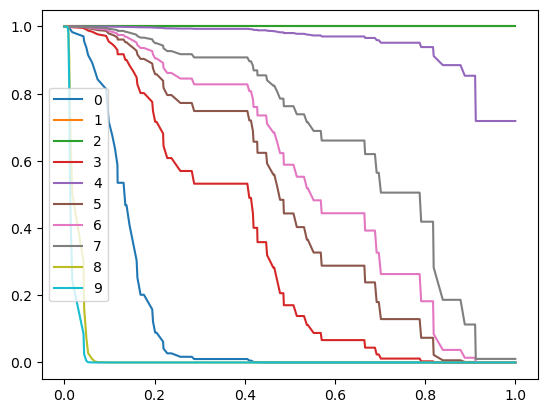

In [13]:
cph.predict_survival_function(final_df.iloc[0:10, :]).plot()

In [17]:
cph.print_summary()

## Optimism computation

In [14]:
np.random.seed(42)
c_b_boot, c_b_orig = [], []
num_bootstraps = 1000
bootstrap_size = len(final_df)

for i in range(num_bootstraps):
    choices = np.random.choice(np.arange(0, len(final_df)), size=bootstrap_size, replace=True)
    new_df = final_df.iloc[choices]  #sample bootstrap replicate with replacement

    cph = CoxPHFitter()
    cph.fit(new_df, duration_col='OS', event_col='FUS')  #fit on bootstrap

    c = cph.score(new_df, scoring_method="concordance_index")  #score on bootstrap
    c_b_boot.append(c)

    c = cph.score(final_df, scoring_method="concordance_index")  #score on original
    c_b_orig.append(c)

c_b_orig = np.array(c_b_orig)
c_b_boot = np.array(c_b_boot)

C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\lifelines\utils\__init__.py:989: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]
C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\lifelines\utils\__init__.py:1146: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in df.iteritems():
C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\lifelines\fitters\coxph_fitter.py:976: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently in 500 steps.

  warnings.warn("Newton-Rhaphson failed to converge sufficiently in %d steps.\n" % max_steps, utils.ConvergenceWarning)
C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\lifelines\utils\__init__.py:940: UserWarning: DataFrame Index is not unique, defaulting to

ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.

In [19]:
o = np.mean(c_b_boot - c_b_orig)
print("measure of optimism: %.3f" % o)

measure of optimism: 0.108


In [20]:
c_final = c_main - o
print("optimism-corrected c-index is %.3f" % c_final)

optimism-corrected c-index is 0.651


# 95% Confidence Intervals


In [21]:
np.random.seed(42)
c_indices = []
num_bootstraps = 1000
bootstrap_size = len(final_df)

cph = CoxPHFitter() #fit on original data
cph.fit(final_df, duration_col='OS', event_col='FUS')

for i in range(num_bootstraps):
    choices = np.random.choice(np.arange(0, len(final_df)), size=bootstrap_size, replace=True)
    new_df = final_df.iloc[choices]

    c_index = cph.score(new_df, scoring_method="concordance_index")
    c_indices.append(c_index)

c_indices.sort()
hi = c_indices[974]
lo = c_indices[24]

print("Confidence interval is: %.3f - %.3f" % (lo, hi))

C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\lifelines\utils\__init__.py:989: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]
C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\lifelines\utils\__init__.py:940: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\lifelines\utils\__init__.py:940: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\lifelines\utils\__init__.py:940: UserWarning: DataFrame Index is not unique, defa

Confidence interval is: 0.695 - 0.819


C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\lifelines\utils\__init__.py:940: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\lifelines\utils\__init__.py:940: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\lifelines\utils\__init__.py:940: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\lifelines\utils\__init__.py:940: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnin

In [22]:
print("Adjusting for optimism")
print("Adjusted confidence interval is: %.3f - %.3f" % (lo-o, hi-o))

Adjusting for optimism
Adjusted confidence interval is: 0.588 - 0.712


# Results

# Clinical features only
Optimism = 0.074

Final c-index: 0.674

Adjusted 95% CI: (0.613, 0.734)

# KimiaNet extracted features only
Optimism = 0.223

Final c-index = 0.686

Adjusted 95% CI: (0.631, 0.736)

# Clinical + extracted features
Optimism = 0.203

Final c-index = 0.738

Adjusted 95% CI: (0.703, 0.769)